In [1]:
# Importieren der benötigten Bibliotheken

# Datenmanipulation
import pandas as pd
import pickle

# Visualisierung
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

# Finales Modell: Hyperparameter Tuning


In [2]:
# Einlesen der Trainings- und Testdaten
destination_path = "../data/processed"

features_train = pd.read_csv(f"{destination_path}/features_train.csv")
features_test = pd.read_csv(f"{destination_path}/features_test.csv")
target_train = pd.read_csv(f"{destination_path}/target_train.csv")
target_test = pd.read_csv(f"{destination_path}/target_test.csv")

# Zielvariablen in einem Dictionary organisieren
targets = {
    "compressor": {
        "train": target_train.iloc[:, 0],
        "test": target_test.iloc[:, 0]
    },
    "turbine": {
        "train": target_train.iloc[:, 1],
        "test": target_test.iloc[:, 1]
    }
}

**Feature Selection**


In [3]:
# Einlesen der Top 10 Features importances basierend auf den Ergebnissen aus 03_baseline_model.ipynb
result_path = "../data/results"
top_features_comp = pd.read_csv(f"{result_path}/top_10_feature_importances_compressor.csv")
top_features_turb = pd.read_csv(f"{result_path}/top_10_feature_importances_turbine.csv")

# Auswahl der Top N Features Importances 
N_TOP_FEATURES = 3

important_features = {
    "compressor": top_features_comp.head(N_TOP_FEATURES)["Feature"].tolist(),
    "turbine": top_features_turb.head(N_TOP_FEATURES)["Feature"].tolist()
} 

print(f"Top {N_TOP_FEATURES} Features:")
print(f"Kompressor: {important_features['compressor']}")
print(f"Turbinen: {important_features['turbine']}")

Top 3 Features:
Kompressor: ['gt_compressor_outlet_air_temperature_t2_c', 'hp_turbine_exit_pressure_p48_bar', 'gt_exhaust_gas_pressure_pexh_bar']
Turbinen: ['gt_compressor_outlet_air_pressure_p2_bar', 'gas_generator_rate_of_revolutions_ggn_rpm', 'gas_turbine_gt_shaft_torque_gtt_kn_m']


**Hyperparameter-Optimierung mit GridSearchCV**


In [4]:
# Parameter-Grid für den Random Forest
param_grid = {
    "n_estimators": [100, 200, 400],
    "max_depth": [None, 20, 30],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

best_models = {}

# Schleife für Kompressor und Turbine
for target_name, target_data in targets.items():
    print(f"GridSearchCV für: {target_name}")

    # Feature Selection für Kompressor und Turbine
    current_features = important_features[target_name]
    features_train_select = features_train[current_features]

    # Initialisierere die Grid Search
    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')

    # Trainiere mit den ausgewählten Features
    grid_search.fit(features_train_select, target_data["train"]) # Führe die Grid Search durch
    best_models[target_name] = grid_search.best_estimator_ 
    
    print(f"Beste Parameter: {grid_search.best_params_}")
    print(f"Bester R2 (CV): {grid_search.best_score_:.4f}\n")

GridSearchCV für: compressor
Beste Parameter: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 400}
Bester R2 (CV): 0.9758

GridSearchCV für: turbine
Beste Parameter: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Bester R2 (CV): 0.9647



**Finale Evaluation und Speicherung**


Finale Performance compressor auf Test-Set
R2 Score: 0.9771

Finale Performance turbine auf Test-Set
R2 Score: 0.9659



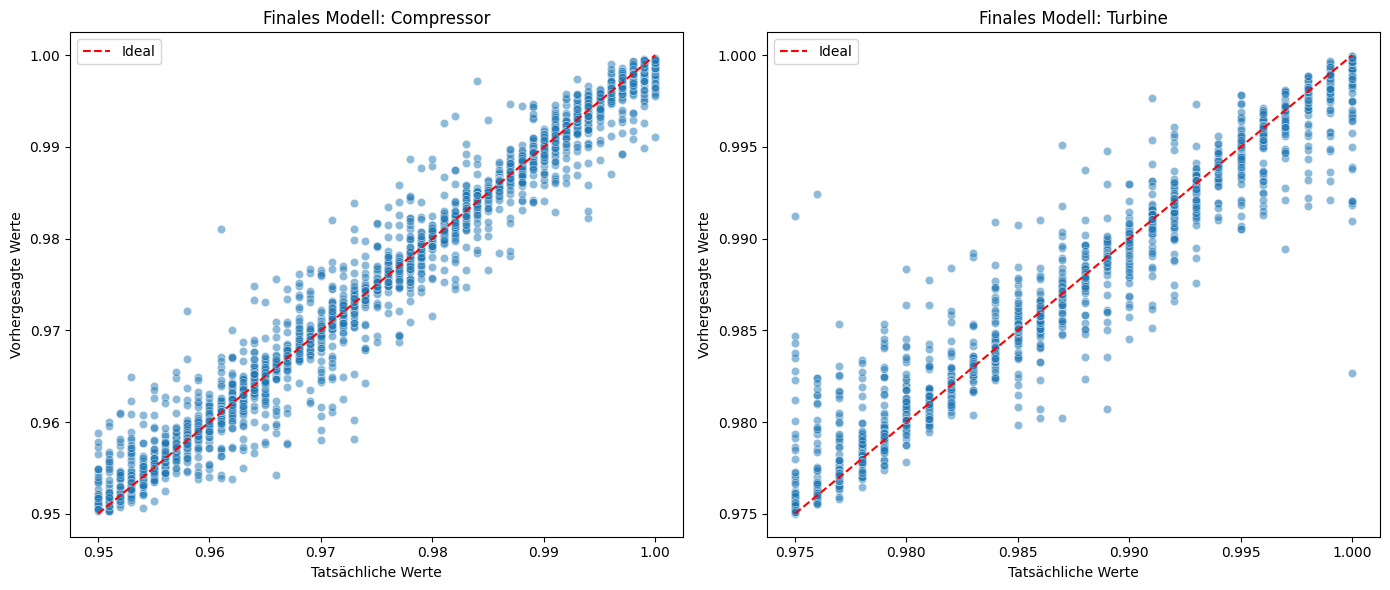

In [5]:
# Evaluieren und Speichern der optimierten Modelle
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Schleife für Kompressor und Turbine
for i, (target_name, best_model) in enumerate(best_models.items()):
    # Vorhersagen auf dem Test-Set
    current_features = important_features[target_name]
    features_test_select = features_test[current_features]
    
    predictions = best_model.predict(features_test_select)
    r2 = r2_score(targets[target_name]['test'], predictions)
    
    print(f"Finale Performance {target_name} auf Test-Set")
    print(f"R2 Score: {r2:.4f}\n")
    
    # Speichern des Modells
    with open(f"../data/models/final_model_{target_name}.pkl", "wb") as file:
        pickle.dump(best_model, file)

    # Visualisierung der Vorhersagen
    ax = axes[i]
    sns.scatterplot(x=targets[target_name]["test"], y=predictions, alpha=0.5, ax=ax)

    ax.plot([targets[target_name]["test"].min(), targets[target_name]["test"].max()], 
             [targets[target_name]["test"].min(), targets[target_name]["test"].max()], 'r--', label='Ideal')
    ax.set_title(f'Finales Modell: {target_name.capitalize()}')
    ax.set_xlabel('Tatsächliche Werte')
    ax.set_ylabel('Vorhergesagte Werte')
    ax.legend()

plt.tight_layout()
plt.show()